In [1]:
import numpy as np
import pandas as pd
import dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [2]:
# Loads a single scan from given folder path

def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [3]:
# convert the single scan values into Hounsfield Units (HUs)

def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [4]:
# adjusts the single scan to have slices exactly 'z'cm distance from one another
# along the z-, x-, and y-axs

def resample(image,
             scan,
             new_spacing = [3,3,3]): # set distance in cm between each slice and between pixels
    
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)
#     print('        Original spacing', spacing)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
#     print('        Resampled spacing', new_spacing)
    
#     print("        Shape before resampling\t", image.shape)
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
#     print("        Shape after resampling\t", image.shape)

    return image, new_spacing

In [5]:
# segments a single scan between lung and non-lung

def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

def segment_lung_mask(image, fill_lung_structures=True):
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0]
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image

In [6]:
# removes zero-arrays from all axes of a single scan

def remove_zeros(nparray):
#     print ('        Original shape..', nparray.shape)
    zaxis = np.stack([z for z in nparray if np.sum(z) != 0])
#     print ('        Shape after z-axis sliced..', zaxis.shape)
    xaxis = np.swapaxes(np.stack([x for x in np.swapaxes(zaxis,0,1) if np.sum(x) != 0]), 0,1)
#     print ('        Shape after x-axis sliced..', xaxis.shape)
    yaxis = np.swapaxes(np.stack([y for y in np.swapaxes(xaxis,0,2) if np.sum(y) != 0]), 0,2)
#     print ('        Shape after y-axis sliced..', yaxis.shape)
    
    return yaxis

In [7]:
# load list of patients by directory in data

path_data = '/home/gantos/data/stage1/'
patients = os.listdir(path_data)

In [8]:
# removing patients that error out

errors = ['b8bb02d229361a623a4dc57aa0e5c485']
errors_idx = [patients.index(i) for i in errors]

print ('Original number of patients..', len(patients))
for i in errors_idx:
    del patients[i]
print ('Number of patients without errors..', len(patients))

Original number of patients.. 1595
Number of patients without errors.. 1594


In [9]:
# begin processing each patient
# from LOAD >> to SMALLEST VOLUME OF MASKED LUNG

zxy_max = [0,0,0]
path_processed_data = '/home/gantos/processed_data/'
counter = 0

for patient in patients:
    
    try:
#         print ('Loading scan..', patient)
        patient_load = load_scan(path_data + patient)

#         print ('    Converting to HU..')
        patient_pixels = get_pixels_hu(patient_load)

#         print ('    Resampling..')
        patient_array,_ = resample(patient_pixels, patient_load, [3,3,3])   

#         print ('    Segmenting..')
        patient_array = segment_lung_mask(patient_array)

#         print ('    Removing zeros..')
        patient_array = remove_zeros(patient_array)

        zxy_patient = patient_array.shape
        zxy_max = list(map(max, zip(zxy_max, zxy_patient)))

        np.save(path_processed_data+patient, patient_array)
        np.save(path_processed_data+'zxy_max', zxy_max)
    
    except:
        print ('Error.. ', patient)
        errors.append(patient)
        np.save(path_processed_data+'errors', errors)
    
    counter += 1
    if counter%100 == 0:
        print ('Processed..', counter)


/home/gantos/.local/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Processed.. 100
Processed.. 200
Processed.. 300
Processed.. 400
Processed.. 500
Processed.. 600
Processed.. 700
Processed.. 800
Processed.. 900
Processed.. 1000
Processed.. 1100
Processed.. 1200
Processed.. 1300
Processed.. 1400
Processed.. 1500


In [20]:
# adds zero-arrays to all axes of a single scan to create uniform volume sizes

zxy_max = np.load(path_processed_data + 'zxy_max.npy')

def add_zeros(nparray, zxy_max=zxy_max):
    
#     print ('    Original shape..', nparray.shape)
    zMax, xMax, yMax = zxy_max
    z, x, y = nparray.shape
    
    if z < zMax:
        extraSlices = np.zeros((zMax-z, x, y))
        nparray = np.concatenate((nparray, extraSlices), axis=0)
        z, x, y = nparray.shape
#         print ('    Shape after zeros added to z-axis..', nparray.shape)
        
    if x < xMax:
        extraSlices = np.zeros((z, xMax-x, y))
        nparray = np.concatenate((nparray, extraSlices), axis=1)
        z, x, y = nparray.shape
#         print ('    Shape after zeros added to x-axis..', nparray.shape)    
            
    if y < yMax:
        extraSlices = np.zeros((z, x, yMax-y))
        nparray = np.concatenate((nparray, extraSlices), axis=2)
        z, x, y = nparray.shape
#         print ('    Shape after zeros added to y-axis..', nparray.shape)
    
    return nparray

In [15]:
# load list of processed patients by directory in data excluding dimension array

patients_processed = [x for x in os.listdir(path_processed_data) if x != 'zxy_max.npy']
print ('Number of patients processed..', len(patients_processed))

Number of patients processed.. 1594


In [22]:
# begin processing each patient
# from SMALLEST MASKED LUNG >> to UNIFORM SIZE MATRICES

counter = 0

for patient in patients_processed:
#     print ('Adding zeros..', patient[:-4])
    nparray = np.load(path_processed_data + patient)
    np.save(path_processed_data+patient[:-4], add_zeros(nparray, zxy_max))
    
    counter += 1
    if counter%100 == 0:
        print ('Processed..', counter)

Processed.. 100
Processed.. 200
Processed.. 300
Processed.. 400
Processed.. 500
Processed.. 600
Processed.. 700
Processed.. 800
Processed.. 900
Processed.. 1000
Processed.. 1100
Processed.. 1200
Processed.. 1300
Processed.. 1400
Processed.. 1500


Number of arrays.. 1594
Shape of each array.. (134, 101, 137)


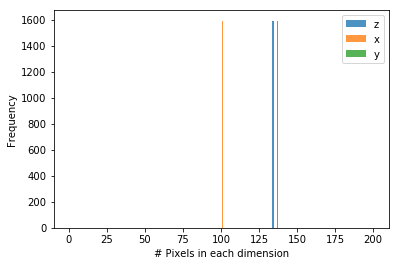

In [2]:
# Check that all of the patients are the same shape

dimensions=[]
for patient in [x for x in os.listdir(path_processed_data) if x != 'zxy_max.npy']:
    dimensions.append(np.load(path_processed_data + patient).shape)
    
print ('Number of arrays..', len(dimensions))
print ('Shape of each array..', dimensions[0])

bins = np.linspace(0, 200, 200)
plt.hist([x[0] for x in dimensions], bins, alpha=0.8, label='z')
plt.hist([x[1] for x in dimensions], bins, alpha=0.8, label='x')
plt.hist([x[2] for x in dimensions], bins, alpha=0.8, label='y')
plt.legend(loc='upper right')
plt.xlabel("# Pixels in each dimension")
plt.ylabel("Frequency")
plt.show()